In [1]:
import numpy as np
from sympy import symbols
from scipy.signal import find_peaks
from mpmath import mp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import copy
import subprocess
from contextlib import redirect_stdout

In [2]:
#Set up mpmath here
mp.prec = 200 # Sets the precision of calculations in bits
print(mp)

Mpmath settings:
  mp.prec = 200               [default: 53]
  mp.dps = 59                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
class SDPAWrapper:
    def __init__(self):
        self.status = None
        self.oval = None
        self.xval = None
    
    def run(self, file='aho'):
        args = ['sdpa_gmp',f'{file}.dat',f'{file}.result']
        subprocess.run(args, stdout=subprocess.DEVNULL)
        with open(f'{file}.result','r') as f:
            lines = f.readlines()
            for lpos, line in enumerate(lines):
                if line.startswith('phase.value'):
                    self.status = line.split(' ')[2]
                if line.startswith('objValPrimal'):
                    self.oval = np.double(line.split(' ')[2])
                if line.startswith('xVec'):
                    self.xval = np.array(lines[lpos + 1][1:-2].split(','), dtype=np.double)

# You do not need to create any more instances of this class
# SDPARunObject runs the data file and stores the status, objective value, and the values of the optimization variables
SDPARunObject = SDPAWrapper()

In [4]:
class Problem:
    def __init__(self, K, problem_name):
        self._K = K
        self._name = problem_name
        self._basis = None
        self._freevars = None
        self._E = symbols('E')

    def _initialize_basis(self):
        raise NotImplementedError

    def _implement_recursion(self):
        raise NotImplementedError

    def _get_free_variables(self):
        raise NotImplementedError

    def initialize_problem(self):
        self._initialize_basis()
        self._implement_recursion()
        self._get_free_variables()


In [ ]:
class HankelProblem(Problem):
    def __init__(self, K, problem_name):
        super().__init__(K, problem_name)
        self._internal_matrix = None
    
    def _get_free_variables(self):
        self._freevars = set()
        for v1 in self._basis:
            for v2 in v1:
                self._freevars |= v2.free_symbols
        # The energy is not a free variable
        self._freevars.discard(self._E)
        self._freevars = list(self._freevars)
    
    def _generate_internal_matrix_structure(self):
        raise NotImplementedError

    def initialize_problem(self):
        super().initialize_problem()
        self._generate_internal_matrix_structure()
        self._generate_unsubstituted_sdpa_matrices()

    def _generate_unsubstituted_sdpa_matrices(self):
        # [F0] + [F1,...,Fc] + [t]
        M = self._internal_matrix
        self._Fs = [np.zeros_like(M)] + [np.zeros_like(M) for _ in range(len(self._freevars))] + [np.eye(M.shape[0])]
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                term = M[i, j]
                for p, var in enumerate(self._freevars, 1):
                    self._Fs[p][i, j] += term.coeff(var)
                    term = term.subs({var: 0})
                self._Fs[0][i, j] -= term

    def _write_input(self, energy, file):
        with redirect_stdout(file):
            print(f'*Energy: {energy}')
            print('*Potential name: ' + self._name)
            print(1 + len(self._freevars)) # mDIM
            print(1) # nBLOCK
            print(self._internal_matrix.shape[0]) # bLOCKsTRUCT
            c = np.zeros(1 + len(self._freevars))
            c[-1] = 1
            print(*c)
            for F in self._Fs:
                for i in range(self._internal_matrix.shape[0]):
                    for j in range(self._internal_matrix.shape[1]):
                        if hasattr(F[i, j], 'subs'):
                            print(mp.mpf(F[i, j].subs({self._E: energy})), end =' ')
                        else:
                            print(mp.mpf(F[i, j]), end=' ')
                print()

    def solve(self, energy, write_to_log=True):
        with open('not_opt.log','a') as logfile:
            with open('aho.dat','w') as datafile:
                self._write_input(energy, datafile)
            SDPARunObject.run()
            if write_to_log == True and SDPARunObject.status != 'pdOPT':
                logfile.write(f'[{datetime.datetime.now()}]: name={self._name} | K={self._K} | status={SDPARunObject.status} | energy={energy}\n')
            return SDPARunObject.oval

In [105]:
class SUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x) - B(x)[P, P\dag].
    A(x) and B(x) are polynomials provided as coefficient lists.
    """
    def __init__(self, K, problem_name, A, B):
        super().__init__(K, problem_name)
        self._A = A
        self._dA = A.shape[0] - 1
        self._B = B
        self._dB = B.shape[0] - 1

    def _initialize_basis(self):
        self._basis = [None] * 2
        self._basis[0] = [symbols(f'x^{i}') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x^{i}PP\dag') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x^0': mp.mpf('1')})
        # self._basis[1][0] = self._basis[1][0].subs({'x^0PP\dag': mp.mpf('1')})

        for t in range(1, len(self._basis[0]) - self._dA + 1):
            ti = mp.mpf(t)
            # Recursion for <x>
            self._basis[0][t + self._dA - 1] = 4*ti*self._E*self._basis[0][t-1]
            if t >= 3:
                self._basis[0][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[0][t-3]
            for n in range(self._dA):
                self._basis[0][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[0][t+n-1]
            for n in range(self._dB + 1):
                self._basis[0][t + self._dA - 1] += (4*ti + 2*n)*self._B[n]*self._basis[1][t+n-1]
            self._basis[0][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)

            # Recursion for <xsigma3>
            self._basis[1][t + self._dA - 1] = 4*ti*self._E*self._basis[1][t-1]
            if t >= 3:
                self._basis[1][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[1][t-3]
            for n in range(self._dA):
                self._basis[1][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[1][t+n-1]
            for n in range(self._dB + 1):
                self._basis[1][t + self._dA - 1] += (4*ti + 2*n)*self._B[n]*self._basis[0][t+n-1]
            self._basis[1][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)
    
    def _generate_internal_matrix_structure(self):
        M0 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        M1 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<xsigma3>

        for i in range(self._K):
            for j in range(self._K):
                # M0
                M0[i, j] = self._basis[0][i + j]
                # M1
                M1[i, j] = self._basis[1][i + j]

        self._internal_matrix = np.block(
            [[M0, M1],
             [M1, M0]])

In [108]:
class NonSUSYProblem(HankelProblem):
    """
    Solves H = p^2 + A(x).
    A(x) is a polynomial provided as a coefficient list.
    """
    def __init__(self, K, problem_name, A):
        super().__init__(K, problem_name)
        self._A = A
        self._dA = A.shape[0] - 1

    def _initialize_basis(self):
        self._basis = [None]
        self._basis[0] = [symbols(f'x^{i}') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x^0': mp.mpf('1')})

        # Recursion for <x>
        for t in range(1, len(self._basis[0]) - self._dA + 1):
            ti = mp.mpf(t)
            self._basis[0][t + self._dA - 1] = 4*ti*self._E*self._basis[0][t-1]
            if t >= 3:
                self._basis[0][t + self._dA - 1] += ti*(ti-1)*(ti-2)*self._basis[0][t-3]
            for n in range(self._dA):
                self._basis[0][t + self._dA - 1] -= (4*ti + 2*n)*self._A[n]*self._basis[0][t+n-1]
            self._basis[0][t + self._dA - 1] /= 2*self._A[-1]*(2*ti+self._dA)
    
    def _generate_internal_matrix_structure(self):
        self._internal_matrix = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        for i in range(self._K):
            for j in range(self._K):
                self._internal_matrix[i, j] = self._basis[0][i + j]

In [109]:
def solve(problem, Es):
    vals = []
    for E in Es:
        vals.append(problem.solve(E))
    return np.array(vals)

In [110]:
A = np.array([0., 0., 0.25])
B = np.array([0.5])
p = SUSYProblem(16, 'x4pot', A, B)
p.initialize_problem()

In [111]:
Es = np.linspace(0, 6, num=200)
ts = solve(p, Es)

In [10]:
A = np.array([-0.5, 0., 0.25])
p2 = NonSUSYProblem(16, 'x4pot', A)
p2.initialize_problem()

In [ ]:
ts2 = solve(p2, Es)

In [15]:
A = np.array([0.5, 0., 0.25])
p3 = NonSUSYProblem(16, 'x4pot', A)
p3.initialize_problem()

In [16]:
ts3 = solve(p3, Es)

In [113]:
A = np.array([0., 0., 0.25])
p4 = NonSUSYProblem(16, 'x4pot', A)
p4.initialize_problem()

In [114]:
ts4 = solve(p4, Es)

[0.54271357 0.99497487 1.98994975 2.83417085 3.40703518]
[ 1.15913731e+08  1.64463925e+01 -4.12841669e-03 -7.34371511e-05
 -2.64399379e-03]


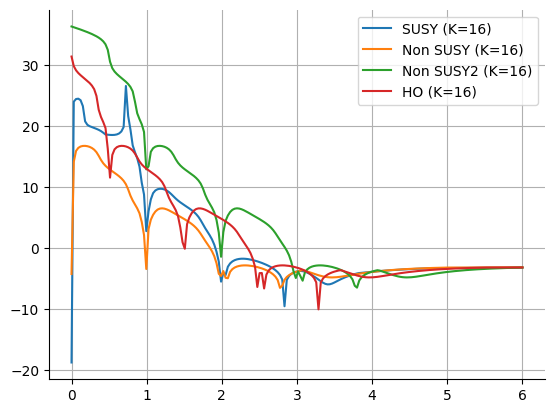

In [115]:
sns.lineplot(x=Es, y=np.log(np.fabs(ts)), label='SUSY (K=16)')
sns.lineplot(x=Es, y=np.log(np.fabs(ts2)), label='Non SUSY (K=16)')
sns.lineplot(x=Es, y=np.log(np.fabs(ts3)), label='Non SUSY2 (K=16)')
sns.lineplot(x=Es, y=np.log(np.fabs(ts4)), label='HO (K=16)')
sns.despine()
peaks = find_peaks(-np.log(np.fabs(ts)),prominence=1)[0]
dips = Es[peaks]
print(dips)
print(ts[peaks])
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
# peaks = find_peaks(-np.log(np.fabs(ts2)),prominence=1)[0]
# dips = Es[peaks]
# print(dips)
# print(ts2[peaks])
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='red',alpha=0.7,zorder=-2)
plt.grid()
plt.legend()
plt.show()

In [73]:
t = p.solve(0.49748744)

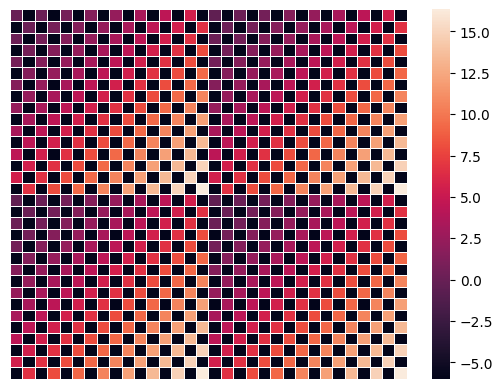

In [74]:
s = []
K = 16
with open('aho.result','r') as rfile:
    lines = rfile.readlines()
    for lpos, line in enumerate(lines):
        if line.startswith('xMat'):
            for i in range(2*K-1):
                s.append(np.double(lines[lpos+2+i][3:-4].split(',')))
            s.append(np.double(lines[lpos+2+2*K-1][3:-7].split(',')))
            s=np.array(s)
            break
s -= np.eye(2*K)*t
ax = sns.heatmap(np.log10(1e-6+np.abs(s)), linewidth=0.5)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.show()

In [36]:
t = p2.solve(0.99497487)

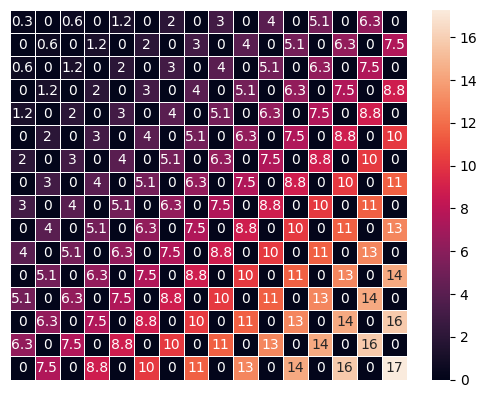

In [37]:
s = []
K = 16
with open('aho.result','r') as rfile:
    lines = rfile.readlines()
    for lpos, line in enumerate(lines):
        if line.startswith('xMat'):
            for i in range(K-1):
                s.append(np.double(lines[lpos+2+i][3:-4].split(',')))
            s.append(np.double(lines[lpos+2+K-1][3:-7].split(',')))
            s=np.array(s)
            break
s -= np.eye(K)*t
ax = sns.heatmap(np.log10(1+np.abs(s)), linewidth=0.5, annot=True)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.show()